<a href="https://colab.research.google.com/github/jerry26432341/myTheses/blob/main/d2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas matplotlib jieba scikit-learn gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import jieba as jb
import re
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from google.colab import drive

# 掛載Google Drive
drive.mount('/content/drive')

# 讀取CSV檔案
df = pd.read_csv('/content/drive/MyDrive/shopping.csv')
df=df[['cat','review']]
print("数据总量: %d ." % len(df))
df.sample(10)


Mounted at /content/drive
数据总量: 62774 .


,cat,review
40148,衣服,料子特别舒服，颜色我也很喜欢
33152,洗发水,扣的四分都是给物流的，配送时没接到电话，没有征求顾客意见，就直接放在街边的店里代收快递，*一...
10639,平板,垃圾东西，买给老爸用的，不到一个月时间手机无故黑屏，没有任何反应，本想着自己维修下，不用等京...
1376,书籍,开始看得平平无奇，但是随着一步步的深入才知道这一切只是铺垫，当结局踩着这条毯子走来时，虽然知...
7058,平板,总体来说，不错
40287,衣服,前天买的今天就到了，卖家发货速度加快递速度真的是没谁了！而且客服态度非常好，就是冲着这态度都...
38803,衣服,裤子很不错 弹性很好 颜色也很正 以后就来这里买啦 我已经介绍小伙伴们来啦
49165,计算机,配置较高，没什么噪声，运行时很安静，散热好，DVD刻录，加装上一条1G内存，速度很不错
2777,书籍,太常识性的东西了稍微有些英文基础的人都不会犯这些错误建议没什么英文基础的人拿去当笑话读读还可以
54935,酒店,"地点不是很好,虽然有路标,但还是有点难找.房间够大,看窗外时视野很宽.设施齐全,包括需要消费..."


In [ ]:
print("在 cat 列中总共有 %d 个空值." % df['cat'].isnull().sum())
print("在 review 列中总共有 %d 个空值." % df['review'].isnull().sum())
df[df.isnull().values==True]
df = df[pd.notnull(df['review'])]
df = df.reset_index(drop=True)

在 cat 列中总共有 0 个空值.
在 review 列中总共有 1 个空值.


   cat  count
0   平板  10000
1   水果  10000
2  洗发水  10000
3   衣服  10000
4   酒店  10000
5  计算机   3992
6   书籍   3851
7   手机   2323
8   蒙牛   2033
9  热水器    575


Text(0.5, 0, '類目')

/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 39006 (\N{CJK UNIFIED IDEOGRAPH-985E}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) m

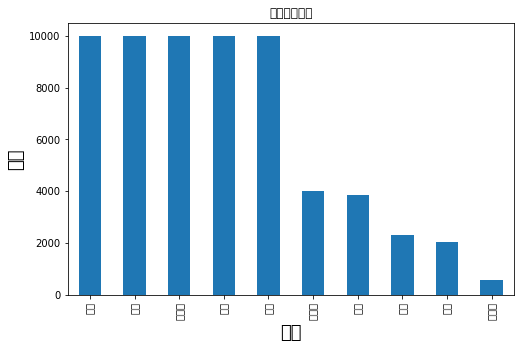

In [ ]:
d = {'cat':df['cat'].value_counts().index, 'count': df['cat'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
print(df_cat)

df_cat.plot(x='cat', y='count', kind='bar', legend=False,  figsize=(8, 5))
plt.title("類目数量分布")
plt.ylabel('數量', fontsize=18)
plt.xlabel('類目', fontsize=18)

In [ ]:
#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line

#停用词列表
def stopwordslist(filepath):
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
    return stopwords

#加载停用词
stopwords = stopwordslist('/content/drive/MyDrive/chineseStopWords.txt')

#删除除字母,数字，汉字以外的所有符号
df['clean_review'] = df['review'].apply(remove_punctuation)

#分词，并过滤停用词
# df['cut_review'] = df['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df['cut_review'] = df['clean_review'].apply(lambda x: [w for w in list(jb.cut(x)) if w not in stopwords])
df.head()

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 2.385 seconds.
DEBUG:jieba:Loading model cost 2.385 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,cat,review,clean_review,cut_review
0,书籍,﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...,做父母一定要有刘墉这样的心态不断地学习不断地进步不断地给自己补充新鲜血液让自己保持一颗年轻的...,"[做, 父母, 一定, 刘墉, 心态, 不断, 学习, 不断, 进步, 不断, 补充, 新鲜..."
1,书籍,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...,作者真有英国人严谨的风格提出观点进行论述论证尽管本人对物理学了解不深但是仍然能感受到真理的火...,"[作者, 真有, 英国人, 严谨, 风格, 提出, 观点, 进行, 论述, 论证, 物理学,..."
2,书籍,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点为什么荷兰曾经县有欧洲最高的生产率...,"[作者, 长篇大论, 借用, 详细, 报告, 数据处理, 工作, 计算结果, 支持, 其新,..."
3,书籍,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...,作者在战几时之前用了拥抱令人叫绝日本如果没有战败就有会有美军的占领没胡官僚主义的延续没有战后...,"[作者, 战, 之前, 拥抱, 令人, 叫绝, 日本, 没有, 战败, 会, 美军, 占领,..."
4,书籍,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...,作者在少年时即喜阅读能看出他精读了无数经典因而他有一个庞大的内心世界他的作品最难能可贵的有两...,"[作者, 少年, 时即, 喜, 阅读, 看出, 精读, 无数, 经典, 一个, 庞大, 内心..."


In [ ]:
#创建训练集和测试集
train, test = train_test_split(df, test_size=0.3, random_state=42,stratify = df.cat.values)

#创建标签化文档
train_tagged = train.apply(
    lambda r: TaggedDocument(words=r['cut_review'], tags=[r['cat']]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=r['cut_review'], tags=[r['cat']]), axis=1)

In [ ]:
#CPU内核数
cores = multiprocessing.cpu_count()

In [ ]:
from gensim.models import Doc2Vec
from tqdm import tqdm

model_dbow = Doc2Vec(dm=0,  negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 43941/43941 [00:00<00:00, 1240664.23it/s]


In [ ]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 43941/43941 [00:00<00:00, 1204083.99it/s]


CPU times: user 2min 2s, sys: 8.57 s, total: 2min 10s
Wall time: 1min 41s


In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [ ]:
#使用逻辑回归来预测
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.36319226888971484
Testing F1 score: 0.342317795074027


In [ ]:
predictions = logreg.predict(X_test)
for i in range(len(predictions)):
    print(f"File {test.index[i]} is classified as {predictions[i]}")


串流輸出內容已截斷至最後 5000 行。
File 919 is classified as 酒店
File 55126 is classified as 酒店
File 55523 is classified as 酒店
File 19659 is classified as 洗发水
File 9049 is classified as 酒店
File 4043 is classified as 酒店
File 32377 is classified as 水果
File 6612 is classified as 水果
File 54922 is classified as 水果
File 22498 is classified as 水果
File 16688 is classified as 平板
File 31843 is classified as 水果
File 5630 is classified as 衣服
File 48458 is classified as 衣服
File 4431 is classified as 酒店
File 33897 is classified as 洗发水
File 48916 is classified as 平板
File 34076 is classified as 平板
File 22898 is classified as 平板
File 53498 is classified as 酒店
File 10999 is classified as 洗发水
File 1030 is classified as 洗发水
File 41456 is classified as 酒店
File 59782 is classified as 酒店
File 12287 is classified as 酒店
File 27938 is classified as 水果
File 36487 is classified as 平板
File 18913 is classified as 水果
File 33008 is classified as 洗发水
File 53950 is classified as 水果
File 60576 is classified as 酒店
File 46442 is classif